In this notebook we fit linear filters predicting neural activity from sensory inputs.

In [1]:
%matplotlib inline
from copy import deepcopy
from itertools import product as cproduct
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression, Ridge

from aux import Generic
from data import DataLoader, random_chunk_split
from db import make_session, d_models
from lin_fit import fit_h_train_test
from plot import set_font_size

import CONFIG as C

# Fit linear filters

In [2]:
TRAIN_LEN = 32  # s
TEST_LEN = 8  # s

EXPTS = ['white_odor_fluct']
GS = ['g2', 'g3', 'g4', 'g5']

X_NAMES = ['odor_binary', 'odor_pid', 'speed', 'ball', 'v_fwd']
Y_NAMES = sum([[g + sfx for g in GS] for sfx in 'rlsd'], [])

WDWS = {
    'odor_binary': (-3, 1),
    'odor_pid': (-3, 1),
    'speed': (-3, 1),
    'ball': (-3, 1),
    'v_fwd': (-3, 1),
}

METHODS = {
    'odor_binary': 'built-in',
    'odor_pid': 'built-in',
    'speed': 'built-in',
    'ball': 'built-in',
    'v_fwd': 'built-in',
}

PARAMS = {
    'odor_binary': {'model': LinearRegression},
    'odor_pid': {'model': LinearRegression},
    'speed': {'model': LinearRegression},
    'ball': {'model': LinearRegression},
    'v_fwd': {'model': LinearRegression},
}

COLS = list(cproduct(X_NAMES, Y_NAMES))

BINS = np.linspace(-.1, 1, 111)
BINCS = 0.5 * (BINS[:-1] + BINS[1:])

COLORS = {
    'odor_binary': np.array(C.COLORS_RGB['odor_binary'])/255,
    'odor_pid': np.array(C.COLORS_RGB['odor_pid'])/255,
    'speed': np.array(C.COLORS_RGB['speed'])/255,
    'ball': np.array(C.COLORS_RGB['ball'])/255,
    'v_fwd': np.array(C.COLORS_RGB['v_fwd'])/255,
}

### Load trials

In [3]:
session = make_session()
trials = session.query(d_models.Trial).filter(
    d_models.Trial.region == 'dan', d_models.Trial.expt.in_(EXPTS)).all()
session.close()

# load data and create a moving average 
for trial in trials:
    trial.dl = DataLoader(trial, 0, None)

### Fit filters

In [4]:
df_rslt = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_r2 = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])
df_h = pd.DataFrame(columns=COLS, index=[trial.name for trial in trials])

for trial in trials:
    print('Fitting trial {}...'.format(trial.name))
    
    # loop over all x, y variable pairs
    for x_name, y_name in COLS:
        
        rslt = fit_h_train_test(
            trial=trial,
            x_names=[x_name],
            y_name=y_name,
            wdws={x_name: WDWS[x_name]},
            train_len=TRAIN_LEN,
            test_len=TEST_LEN,
            method=METHODS[x_name],
            params=PARAMS[x_name],
            normed=True,
            C=C)
        
        df_rslt.loc[trial.name][(x_name, y_name)] = deepcopy(rslt)
        df_r2.loc[trial.name][(x_name, y_name)] = rslt.r2_test
        df_h.loc[trial.name][(x_name, y_name)] = np.array([rslt.t_hs, rslt.hs])

Fitting trial 20171130.Fly1.1...
Fitting trial 20171130.Fly1.3...
Fitting trial 20171130.Fly1.4...
Fitting trial 20171130.Fly1.6...
Fitting trial 20171130.Fly2.1...
Fitting trial 20171130.Fly2.2...
Fitting trial 20171130.Fly3.1...
Fitting trial 20171130.Fly3.3...
Fitting trial 20171130.Fly3.4...
Fitting trial 20171130.Fly3.6...
Fitting trial 20171130.Fly3.7...
Fitting trial 20171130.Fly4.1...
Fitting trial 20171130.Fly4.3...
Fitting trial 20171130.Fly4.5...
Fitting trial 20171130.Fly4.6...
Fitting trial 20171130.Fly4.8...
Fitting trial 20171130.Fly5.1...
Fitting trial 20171130.Fly5.2...
Fitting trial 20171130.Fly5.3...
Fitting trial 20171130.Fly5.4...
Fitting trial 20171130.Fly5.5...
Fitting trial 20171204.Fly2.1...
Fitting trial 20171204.Fly2.3...
Fitting trial 20171204.Fly2.5...
Fitting trial 20171204.Fly2.6...


# Plot R2 for different filter types

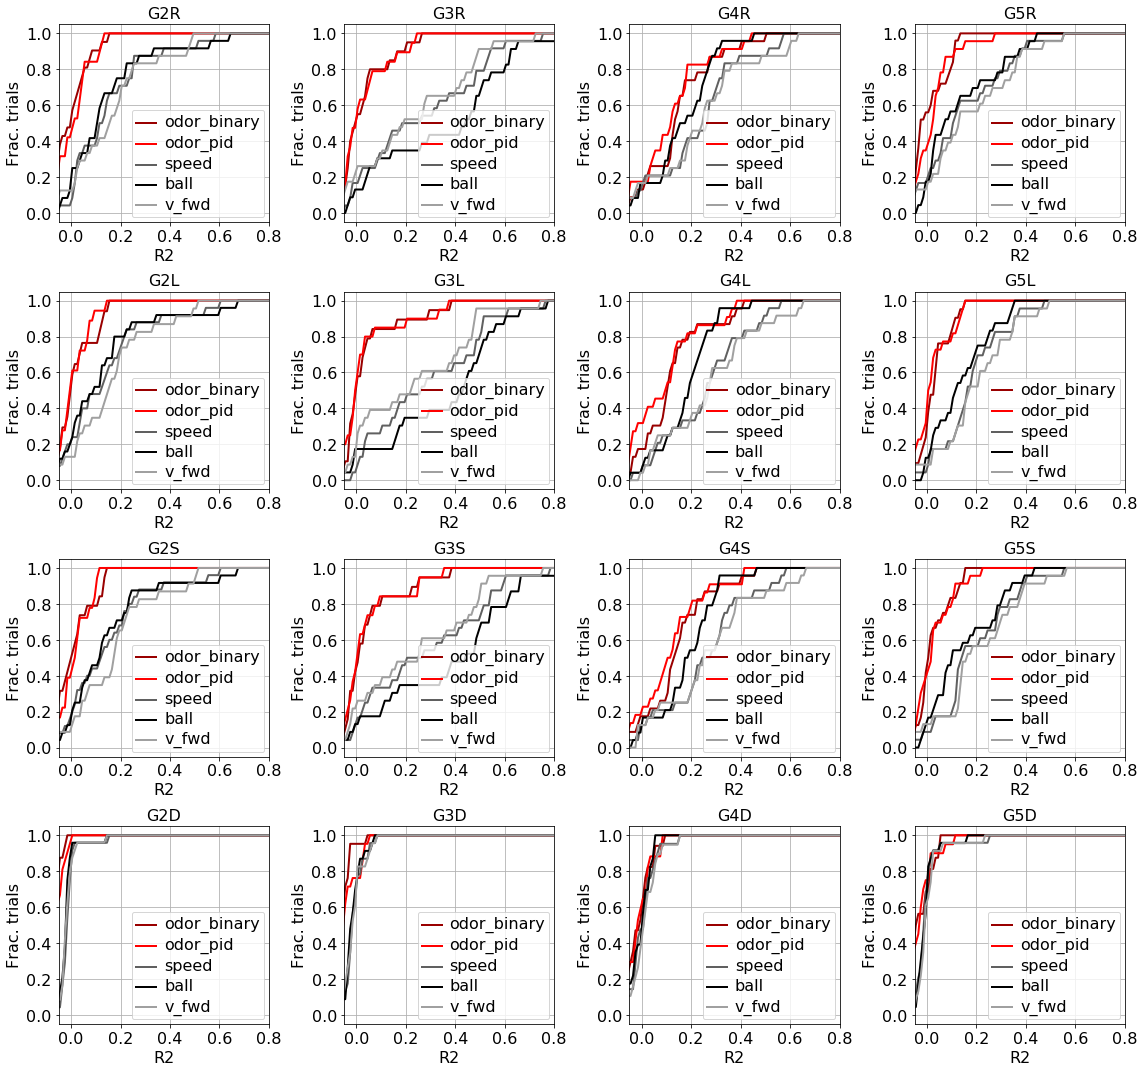

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(16, 15), tight_layout=True)

for ctr, (y_name, ax) in enumerate(zip(Y_NAMES, axs.flatten())):
    for x_name in X_NAMES:
        
        # get all R2s
        r2s = df_r2[(x_name, y_name)].as_matrix()
        
        # plot cumulative histogram
        cts, bins = np.histogram(r2s, bins=BINS)
        cts = cts.cumsum().astype(float)
        cts /= cts[-1]
        
        color = COLORS[x_name]
        
        ax.plot(BINCS, cts, color=color, lw=2)
        
    ax.set_title(y_name.upper())
    
    ax.legend(X_NAMES, ncol=1, loc='best')
        
for ax in axs.flatten():
    ax.set_xlim(-0.05, 0.8)
    ax.set_ylim(-0.05, 1.05)
    
    ax.grid()
    
    ax.set_xlabel('R2')
    ax.set_ylabel('Frac. trials')
    
    set_font_size(ax, 16)

# Show table of select R2 values

In [6]:
df_r2[[('odor_binary', 'g4s'), ('odor_pid', 'g4s'), ('speed', 'g4s'), ('ball', 'g4s'), ('v_fwd', 'g4s')]]

,"(odor_binary, g4s)","(odor_pid, g4s)","(speed, g4s)","(ball, g4s)","(v_fwd, g4s)"
20171130.Fly1.1,0.110005,0.00645131,0.350616,0.316294,0.360569
20171130.Fly1.3,0.108543,0.0766005,0.378572,0.265868,0.387982
20171130.Fly1.4,0.127294,0.128554,0.329733,0.192144,0.373885
20171130.Fly1.6,0.257315,0.258065,0.226494,0.136308,0.251313
20171130.Fly2.1,0.46879,0.411257,0.321226,0.172399,0.32178
20171130.Fly2.2,0.159279,0.136171,-0.587264,-0.939125,-0.925172
20171130.Fly3.1,0.185486,0.0931413,0.309193,0.318585,0.198043
20171130.Fly3.3,0.117833,0.192054,0.452586,0.127905,0.50438
20171130.Fly3.4,-0.0102296,-0.040607,0.0438229,0.136297,0.0259371
20171130.Fly3.6,0.0361674,0.0345451,0.226791,0.171866,0.238023


# Plot select filters

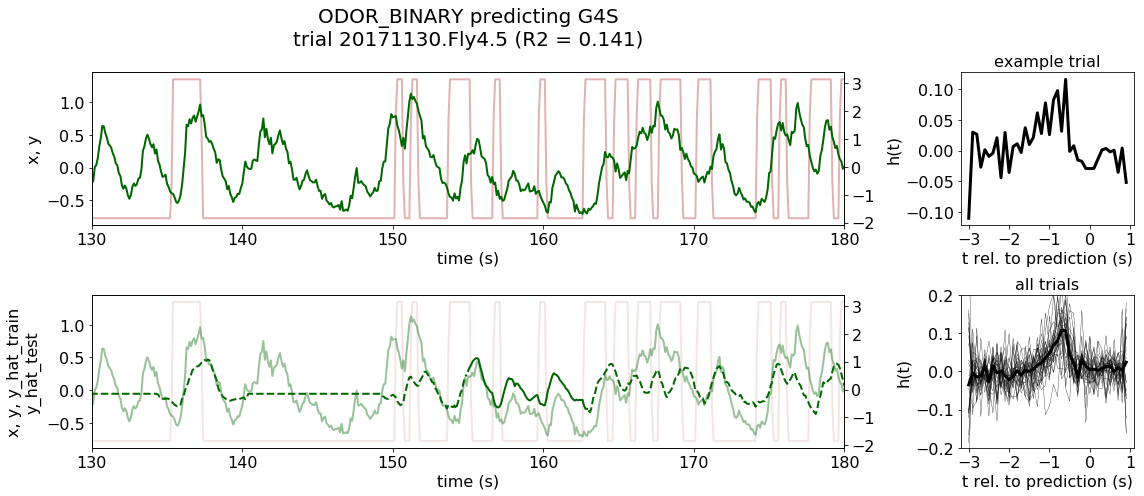

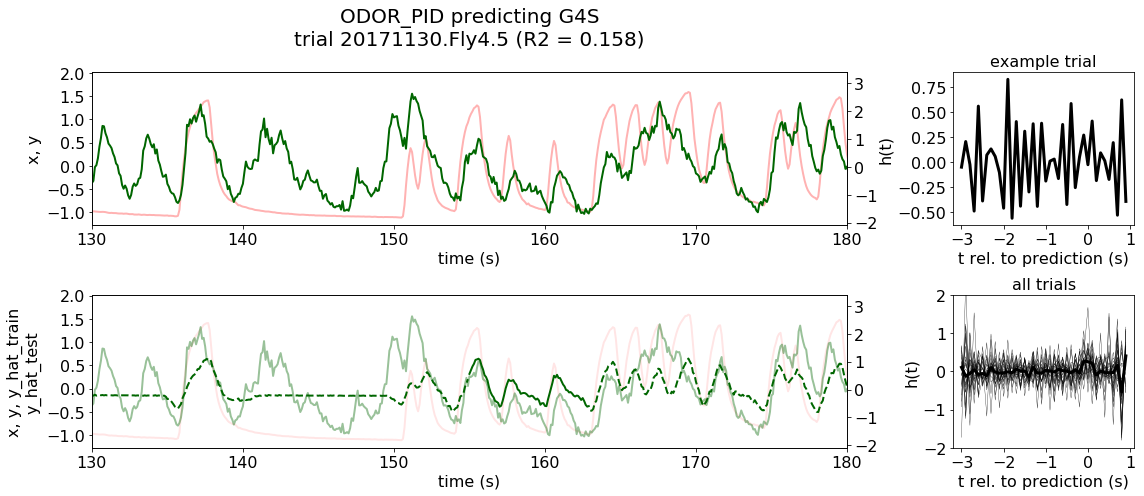

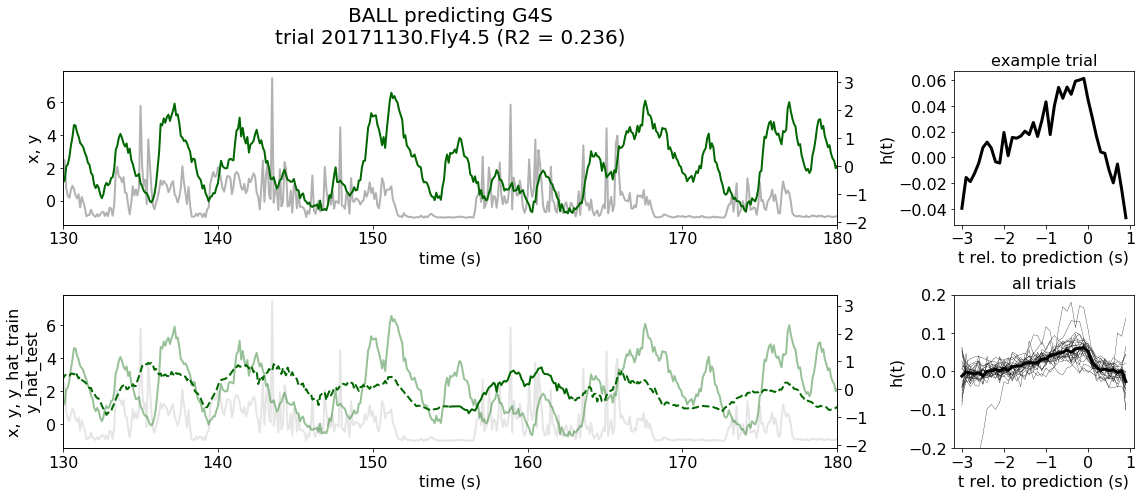

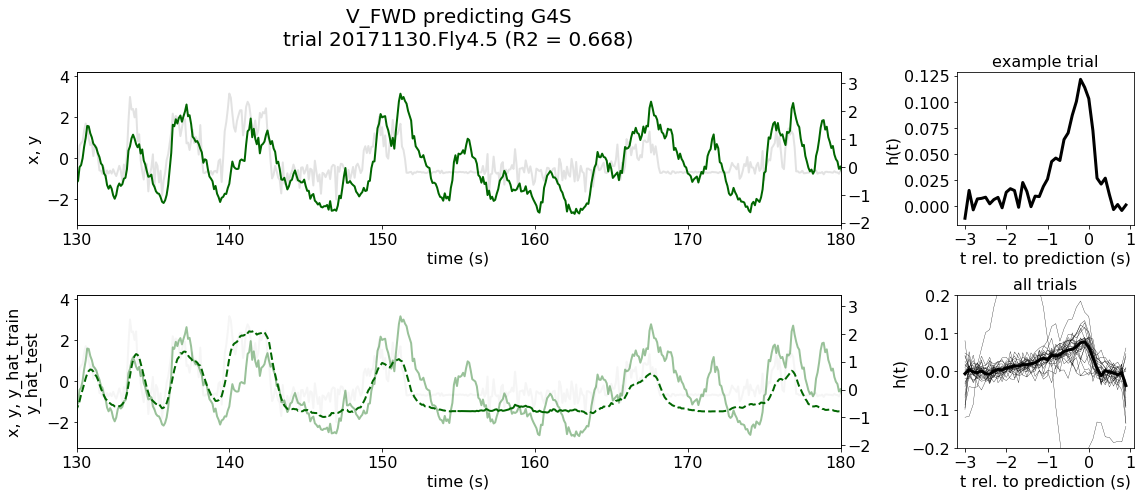

In [7]:
HS_PLOT = [
    ('20171130.Fly4.5', (130, 180), 'odor_binary', 'g4s', (-0.2, 0.2)),
    ('20171130.Fly4.5', (130, 180), 'odor_pid', 'g4s', (-2, 2)),
    ('20171130.Fly4.5', (130, 180), 'ball', 'g4s', (-0.2, 0.2)),
    ('20171130.Fly4.5', (130, 180), 'v_fwd', 'g4s', (-0.2, 0.2)),
]

for trial_name, t_lim, x_name, y_name, y_lim in HS_PLOT:
    
    rslt = df_rslt.loc[trial_name][(x_name, y_name)]
    
    c_x = np.array(C.COLORS_RGB[x_name]) / 255
    c_y = np.array(C.COLORS_RGB[y_name]) / 255
    
    gs = gridspec.GridSpec(2, 4)
    
    fig = plt.figure(figsize=(16, 7), tight_layout=True)
    
    # plot x and y
    ax_0 = fig.add_subplot(gs[0, :3])
    ax_0.plot(rslt.t, rslt.xs[x_name], color=c_x, lw=2, alpha=0.3)
    
    ax_0_twin = ax_0.twinx()
    
    ax_0_twin.plot(rslt.t, rslt.y, color=c_y, lw=2)
    
    ax_0.set_xlim(t_lim)
    
    ax_0.set_xlabel('time (s)')
    ax_0.set_ylabel('x, y')
    ax_0.set_title('{2} predicting {3}\ntrial {0} (R2 = {1:.3f})\n'.format(
        trial_name, rslt.r2_test, x_name.upper(), y_name.upper()))
    
    # plot x, y, y_hat_train, and y_hat_test
    ax_1 = fig.add_subplot(gs[1, :3])
    ax_1.plot(rslt.t, rslt.xs[x_name], color=c_x, lw=2, alpha=0.1)
    
    ax_1_twin = ax_1.twinx()
    
    ax_1_twin.plot(rslt.t, rslt.y, color=c_y, lw=2, alpha=0.4)
    ax_1_twin.plot(rslt.t, rslt.y_hat_train, color=c_y, lw=2, ls='--')
    ax_1_twin.plot(rslt.t, rslt.y_hat_test, color=c_y, lw=2, ls='-')
    
    ax_1.set_xlim(t_lim)
    
    ax_1.set_xlabel('time (s)')
    ax_1.set_ylabel('x, y, y_hat_train\ny_hat_test')
    
    # plot filters
    ## example cross-split mean + std
    t_hs, hs_mean = df_h.loc[trial_name][(x_name, y_name)]
    t_h = t_hs[x_name]
    h_mean = hs_mean[x_name]
    
    ax_2 = fig.add_subplot(gs[0, 3])
    
    ### filter corresponding to example x, y trace
    ax_2.plot(rslt.t_hs[x_name], rslt.hs[x_name], color='k', lw=1)
    
    ### mean/stds of filters across all splits
    ax_2.plot(t_h, h_mean, color='k', lw=3)
    
    ax_2.set_xlabel('t rel. to prediction (s)')
    ax_2.set_ylabel('h(t)')
    ax_2.set_title('example trial')
    
    ## cross-trial median
    t_hs = np.array([df_h.loc[trial.name][(x_name, y_name)][0][x_name] for trial in trials])
    h_means = np.array([df_h.loc[trial.name][(x_name, y_name)][1][x_name] for trial in trials])
    
    ax_3 = fig.add_subplot(gs[1, 3])
    
    ax_3.plot(t_hs.mean(0), h_means.T, color='k', lw=0.3)
    ax_3.plot(t_hs.mean(0), np.median(h_means, 0), color='k', lw=3)
    
    ax_3.set_ylim(y_lim)
    
    ax_3.set_xlabel('t rel. to prediction (s)')
    ax_3.set_ylabel('h(t)')
    ax_3.set_title('all trials')
    
    for ax in [ax_0, ax_0_twin, ax_1, ax_1_twin, ax_2, ax_3]:
        set_font_size(ax, 16)
        
        if ax not in [ax_2, ax_3]:
            ax.title.set_fontsize(20)

### Plot per-trial ODOR_BINARY --> G4S filters and R2 values

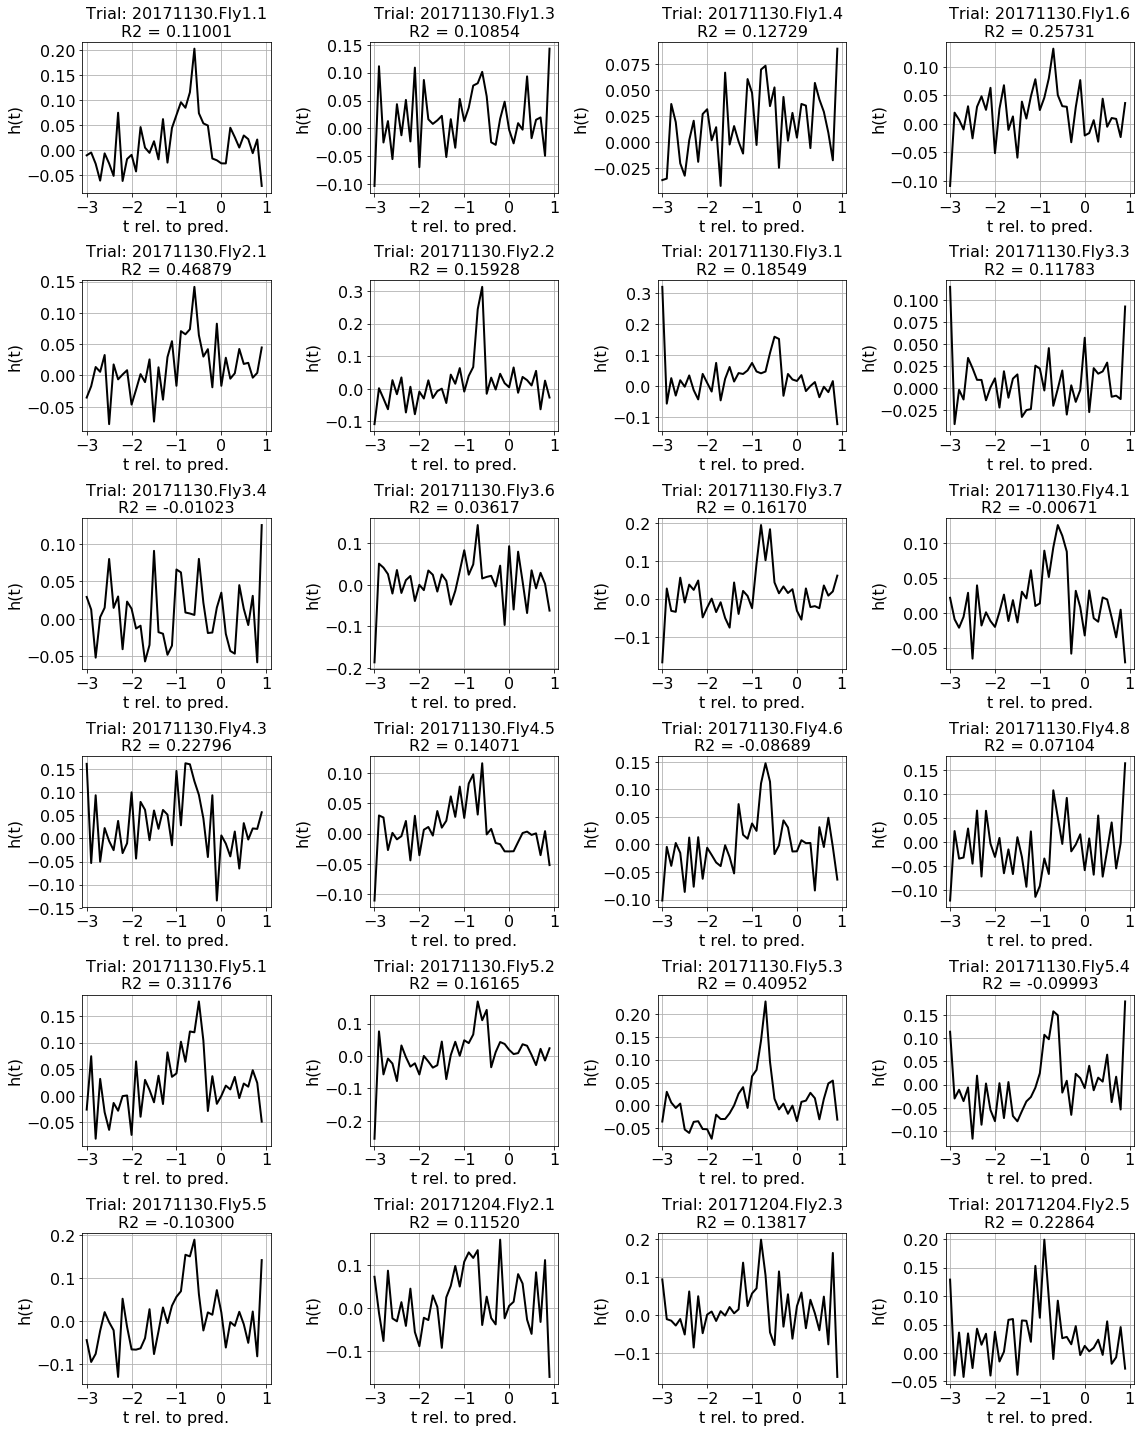

In [8]:
X_NAME = 'odor_binary'
Y_NAME = 'g4s'

fig, axs = plt.subplots(6, 4, figsize=(16, 20), tight_layout=True)

for trial, ax in zip(trials, axs.flatten()):
    
    t_h = df_h.loc[trial.name][(X_NAME, Y_NAME)][0][X_NAME]
    h_mean = df_h.loc[trial.name][(X_NAME, Y_NAME)][1][X_NAME]
    r2 = df_r2.loc[trial.name][(X_NAME, Y_NAME)]
    
    ax.plot(t_h, h_mean, lw=2, c='k')
    ax.set_title('Trial: {0}\nR2 = {1:.5f}'.format(trial.name, r2))
    
for ax in axs.flatten():
    
    ax.set_xlim(-3.1, 1.1)
    
    ax.grid()
    
    ax.set_xlabel('t rel. to pred.')
    ax.set_ylabel('h(t)')
    
    set_font_size(ax, 16)

### Plot per-trial V_FWD --> G4S filters and R2 values

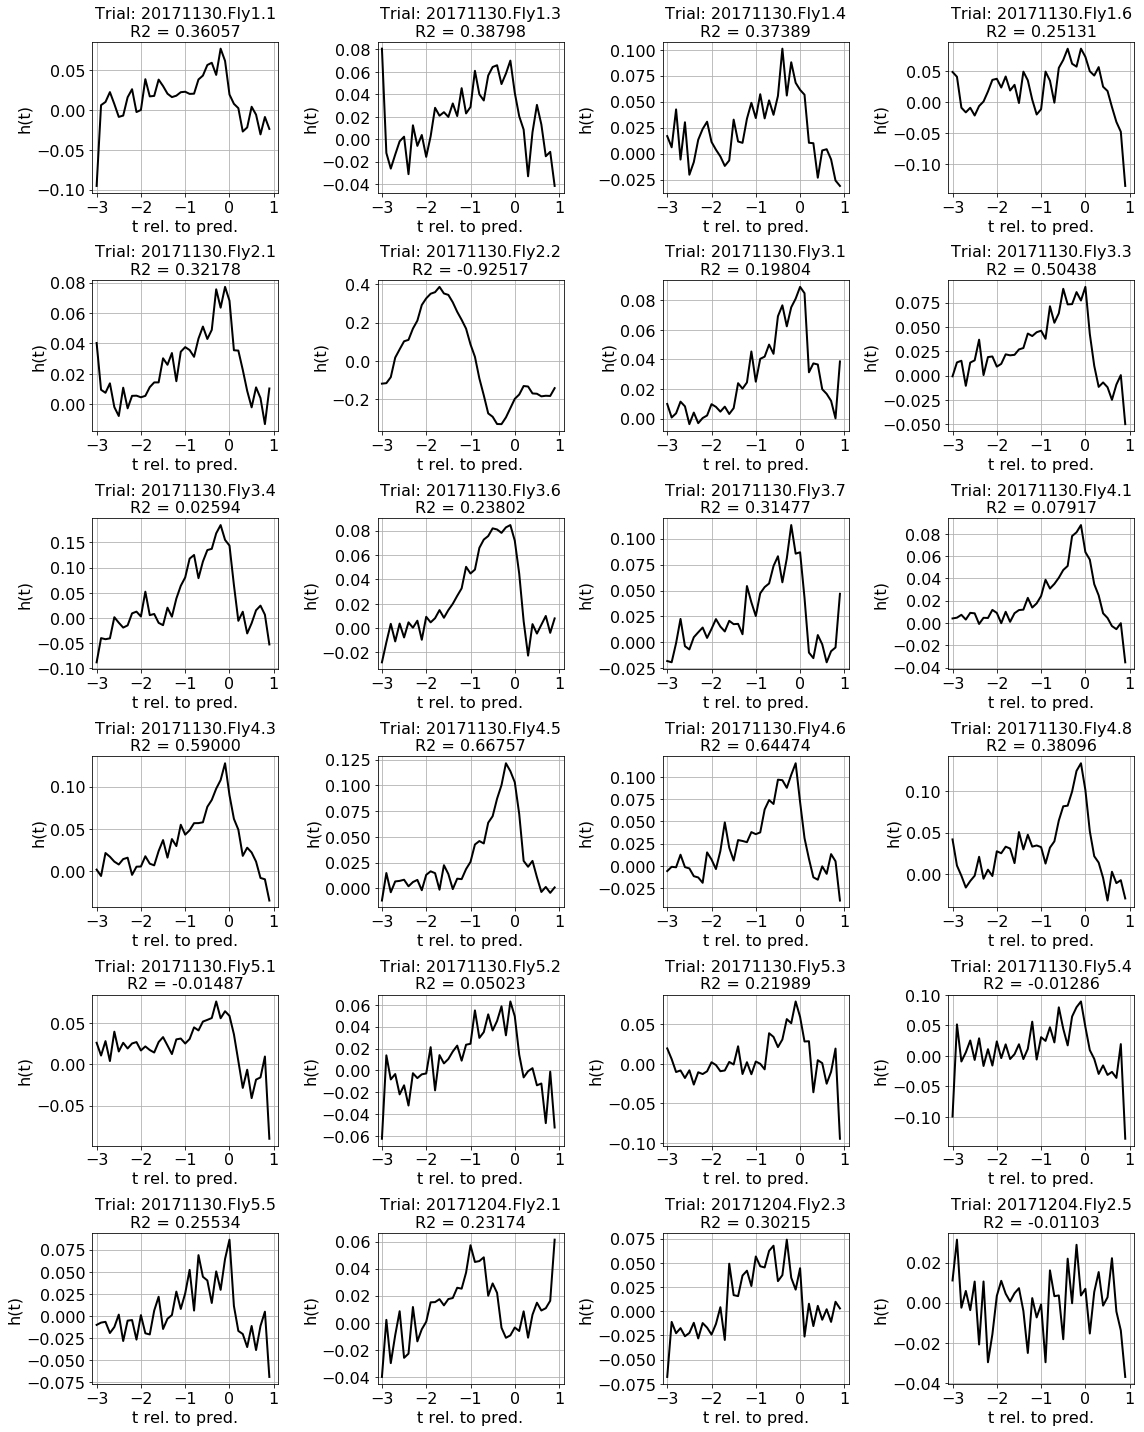

In [9]:
X_NAME = 'v_fwd'
Y_NAME = 'g4s'

fig, axs = plt.subplots(6, 4, figsize=(16, 20), tight_layout=True)

for trial, ax in zip(trials, axs.flatten()):
    
    t_h = df_h.loc[trial.name][(X_NAME, Y_NAME)][0][X_NAME]
    h_mean = df_h.loc[trial.name][(X_NAME, Y_NAME)][1][X_NAME]
    r2 = df_r2.loc[trial.name][(X_NAME, Y_NAME)]
    
    ax.plot(t_h, h_mean, lw=2, c='k')
    ax.set_title('Trial: {0}\nR2 = {1:.5f}'.format(trial.name, r2))
    
for ax in axs.flatten():
    
    ax.set_xlim(-3.1, 1.1)
    
    ax.grid()
    
    ax.set_xlabel('t rel. to pred.')
    ax.set_ylabel('h(t)')
    
    set_font_size(ax, 16)